In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sn


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def get_data_generators():
    train_dir = '/kaggle/input/private-datasetrar/224x224/train'
    valid_dir = '/kaggle/input/private-datasetrar/224x224/valid'
    test_dir = '/kaggle/input/private-datasetrar/224x224/test'

    batch_size = 32
    img_height, img_width = (224, 224)

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.4
    )
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    valid_generator = train_datagen.flow_from_directory(
        directory=valid_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    test_generator = train_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, valid_generator, test_generator


In [3]:
def MobileNetV3LargeNet(input_shape, num_classes):
    base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # set all existing layers to not trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions, name='MobileNetV3LargeNet')

    return model


In [4]:
def compile_and_fit_model(model, train_generator, valid_generator):
    EPOCHS = 50
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath_best = '/kaggle/working/MobileNetV3/50epoch.{epoch:02d}-{val_loss:.2f}.h5'
    checkpoint_best = ModelCheckpoint(
        filepath=checkpoint_filepath_best,
        save_best_only=True,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[checkpoint_best]
    )
    return history


In [5]:
def plot_training_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    # Plot Training Accuracy and Validation Accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('MobileNetV3 Training Accuracy VS Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Training', 'Validation'])

    # Plot Training Loss and Validation Loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('MobileNetV3 Training Loss VS Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()


In [6]:
def save_best_model():
    saved_models_dir = '/kaggle/working/MobileNetV3/'
    saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
    saved_model_files.sort()
    best_model_file = saved_model_files[-1]
    best_model = tf.keras.models.load_model(best_model_file)

    best_model.save('/kaggle/working/MobileNetV3/Best_MobileNetV3.h5')


In [7]:
def evaluate_models(test_generator, train_generator):
    saved_model_filepaths = glob.glob('/kaggle/working/MobileNetV3/*.h5')

    for model_filepath in saved_model_filepaths:
        print("Model file path: {}".format(model_filepath))

        model = tf.keras.models.load_model(model_filepath)

        filenames = test_generator.filenames
        nb_samples = len(filenames)

        y_prob = []
        y_act = []

        test_generator.reset()
        for _ in range(nb_samples):
            X_test, Y_test = test_generator.next()
            y_prob.append(model.predict(X_test))
            y_act.append(Y_test)

        predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
        actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

        out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

        confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

        sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
        plt.title('Confusion Matrix for Model: {}'.format(model_filepath))
        plt.show()

        print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))


Found 1593 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
12683000/12683000 [==============================] - 0s 0us/step
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.8060
Epoch 1: val_accuracy improved from -inf to 0.91247, saving model to /kaggle/working/MobileNetV3/50epoch.01-0.38.h5
50/50 [==============================] - 46s 683ms/step - loss: 0.7762 - accuracy: 0.8060 - val_loss: 0.3792 - val_accuracy: 0.9125
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8895
Epoch 2: val_accuracy improved from 0.91247 to 0.94748, saving model to /kaggle/working/MobileNetV3/50epoch.02-0.19.h5
50/50 [==============================] - 31s 614ms/step - loss: 0.3352 - accuracy: 0.8895 - val_loss: 0.1945 - val_accuracy: 0.9475
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9240
Epoch 3: val_accuracy improved

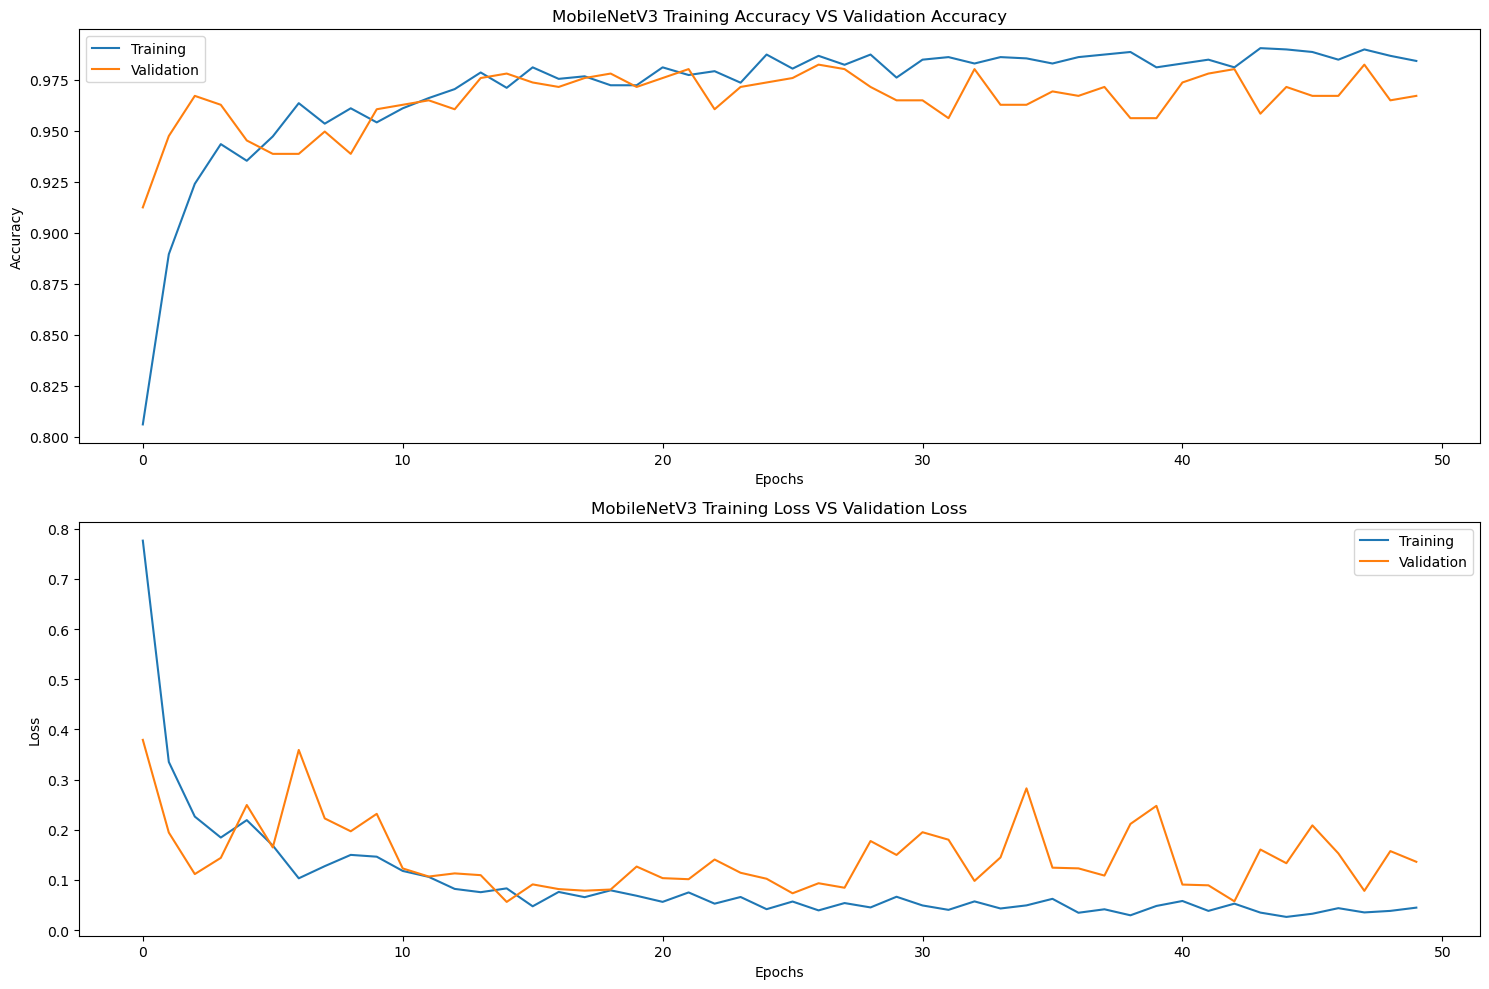

Model file path: /kaggle/working/MobileNetV3/50epoch.03-0.11.h5
1/1 [==============================] - 0s 28ms/step


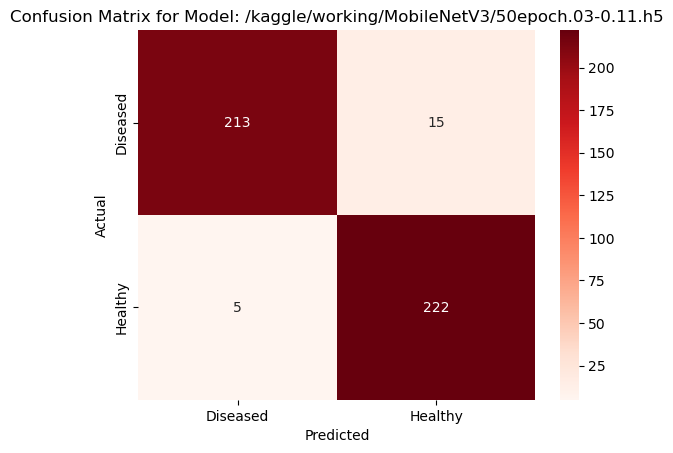

Test accuracy: 95.6043956043956
Model file path: /kaggle/working/MobileNetV3/50epoch.01-0.38.h5
1/1 [==============================] - 0s 30ms/step


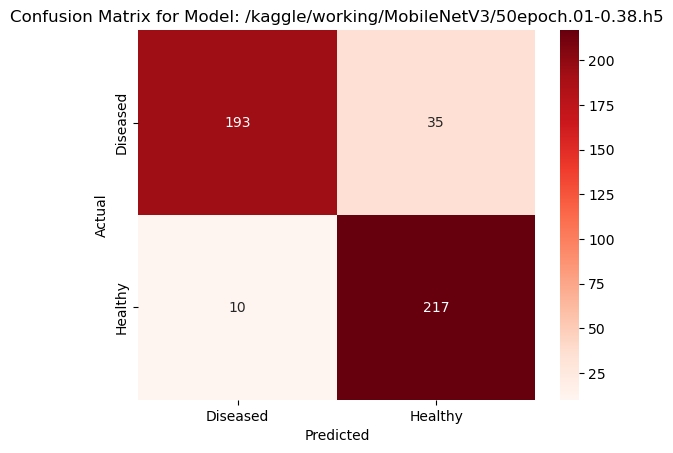

Test accuracy: 90.10989010989012
Model file path: /kaggle/working/MobileNetV3/50epoch.27-0.09.h5
1/1 [==============================] - 0s 28ms/step


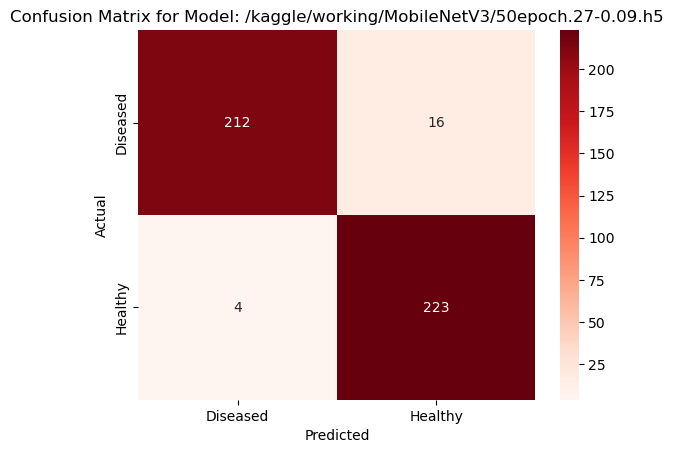

Test accuracy: 95.6043956043956
Model file path: /kaggle/working/MobileNetV3/50epoch.02-0.19.h5
1/1 [==============================] - 0s 29ms/step


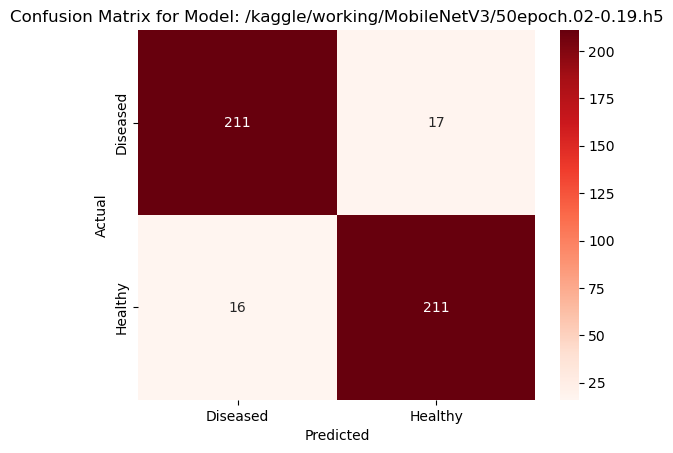

Test accuracy: 92.74725274725274
Model file path: /kaggle/working/MobileNetV3/Best_MobileNetV3.h5
1/1 [==============================] - 0s 30ms/step


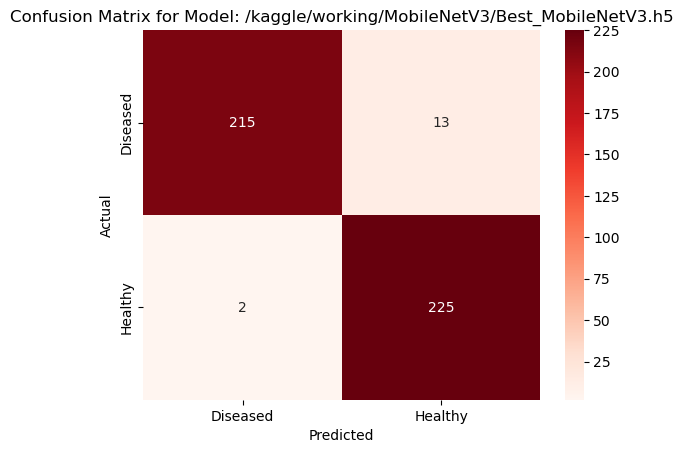

Test accuracy: 96.7032967032967
Model file path: /kaggle/working/MobileNetV3/50epoch.14-0.11.h5
1/1 [==============================] - 0s 28ms/step


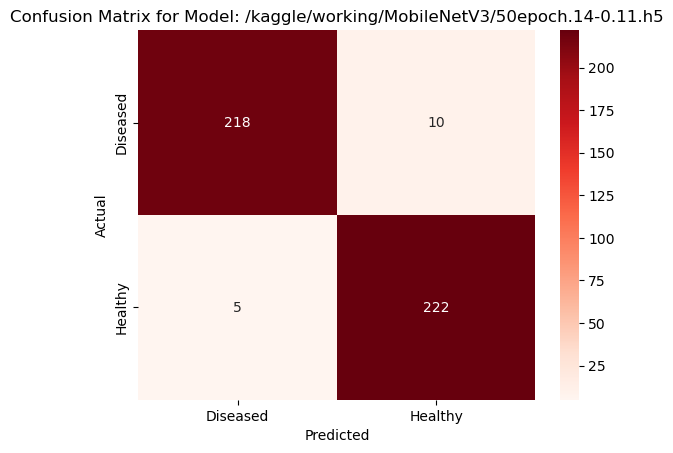

Test accuracy: 96.7032967032967
Model file path: /kaggle/working/MobileNetV3/50epoch.22-0.10.h5
1/1 [==============================] - 0s 34ms/step


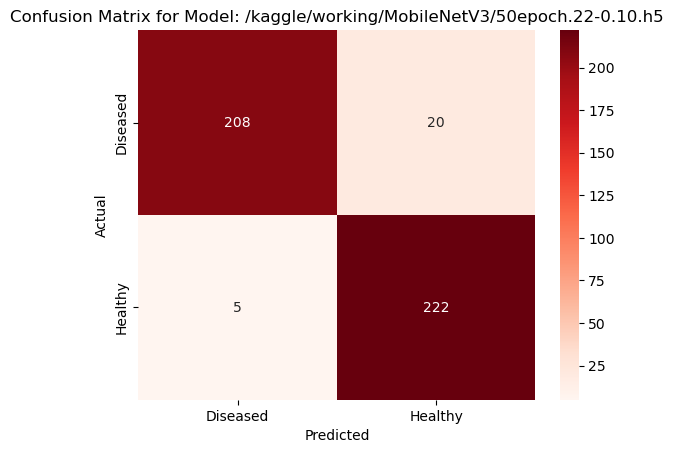

Test accuracy: 94.5054945054945
Model file path: /kaggle/working/MobileNetV3/50epoch.15-0.06.h5
1/1 [==============================] - 0s 28ms/step


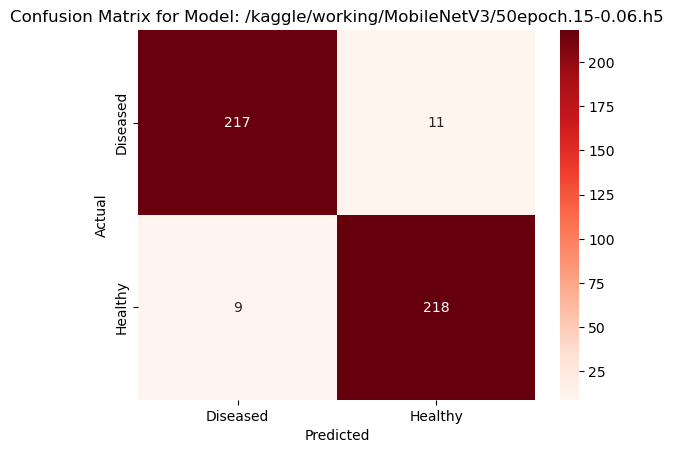

Test accuracy: 95.6043956043956


In [8]:
def main():
    train_generator, valid_generator, test_generator = get_data_generators()
    model = MobileNetV3LargeNet(train_generator.image_shape, train_generator.num_classes)
    history = compile_and_fit_model(model, train_generator, valid_generator)
    plot_training_history(history)
    save_best_model()
    evaluate_models(test_generator, train_generator)

if __name__ == "__main__":
    main()